In [ ]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [1]:
!git clone https://github.com/niazwazir/SRCNN-Keras.git

fatal: destination path 'SRCNN-Keras' already exists and is not an empty directory.


In [2]:
cd SRCNN-Keras/

C:\Users\user\Desktop\ABC\SRCNN-Keras


In [3]:
!ls

Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
prepare_data.py
project.gif
subpixel.py
text
woman_GT.bmp
yang91


In [4]:
!unzip yang91.zip

unzip:  cannot find or open yang91.zip, yang91.zip.zip or yang91.zip.ZIP.


In [5]:
!ls

Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
prepare_data.py
project.gif
subpixel.py
text
woman_GT.bmp
yang91


In [6]:
!rm -r *.zip

rm: cannot remove '*.zip': No such file or directory


In [7]:
!ls

Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
prepare_data.py
project.gif
subpixel.py
text
woman_GT.bmp
yang91


In [8]:
cd ..

C:\Users\user\Desktop\ABC


In [9]:
!ls

FSRCNN_Experimental.ipynb
SRCNN-Keras
best_model_improved.h5
model.png
model2_FCN_FSRCNN.h5
pytorch-LapSRN


In [10]:
!unzip "DIV2K_train_HR.zip"

unzip:  cannot find or open DIV2K_train_HR.zip, DIV2K_train_HR.zip.zip or DIV2K_train_HR.zip.ZIP.


In [11]:
!rm -r *.zip

rm: cannot remove '*.zip': No such file or directory


In [12]:
!ls

FSRCNN_Experimental.ipynb
SRCNN-Keras
best_model_improved.h5
model.png
model2_FCN_FSRCNN.h5
pytorch-LapSRN


In [13]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"

In [14]:
import os
import cv2
import keras
import numpy as np
import tensorflow as tf
#from google.colab.patches import cv2_imshow
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input,Conv2DTranspose, add, Activation, LeakyReLU

In [15]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
    readpath = os.path.join(DATADIR,filera)
    img = cv2.imread(readpath)
    img = np.asarray(img)
    shapes = img.shape
    for i in range(0, shapes[0]-req_size+1, stride):
        for j in range(0, shapes[1]-req_size+1,stride):
            subimage_HR = img[i:i+req_size, j:j+req_size]
            #cv2_imshow(subimage_HR)
            subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
            X.append(subimage_LR)
            labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
    counta=counta+1
    if(counta==300):
        break
        readpath = os.path.join(DATADIR2,filera)
        img = cv2.imread(readpath)
        img = np.asarray(img)
        shapes = img.shape
        for i in range(0, shapes[0]-req_size+1, stride):
            for j in range(0, shapes[1]-req_size+1,stride):
                subimage_HR = img[i:i+req_size, j:j+req_size]
                #cv2_imshow(subimage_HR)
                subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
                X.append(subimage_LR)
                labels.append(subimage_HR)

In [16]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(18849, 20, 20, 3)
(18849, 10, 10, 3)


In [17]:
alpha = 0.85
def basic_mse(y_true, y_pred):
    pred = tf.image.sobel_edges(y_pred)
    true = tf.image.sobel_edges(y_true)
    lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
    lossedge = tf.reduce_mean(tf.square(pred-true))
    return alpha*lossmse + (1-alpha)*lossedge

In [18]:
def Res_block():
    _input = Input(shape=(None, None, 3))

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(_input)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear')(conv1)
    conv3 = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear')(conv2)

    out = add(inputs=[_input, conv3])
    out = Activation('relu')(out)

    model1 = Model(inputs=_input, outputs=out)

    return model1
model1 = Res_block()

In [19]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

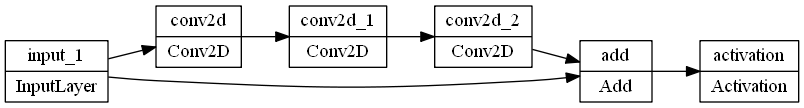

In [20]:
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [21]:
inputlayer = tf.keras.layers.Input(shape=(None,None,3))
C1 = Conv2D(64, (3,3), padding="same")(inputlayer)
L1 = LeakyReLU(alpha=0.2)(C1)
C2 = Conv2D(12, (3,3),padding="same")(L1)
L2 = LeakyReLU(alpha=0.2)(C2)
C3 = Conv2D(3, (3,3),padding="same")(L2)
B1 = Res_block()(C3)
B2 = Res_block()(B1)
sum1 = add(inputs=[inputlayer, B2])
B3 = Res_block()(sum1)
B4 = Res_block()(B3)
sum2 = add(inputs=[inputlayer, B4])
B5 = Res_block()(sum2)
B6 = Res_block()(B5)
B7 = Res_block()(B6)
B8 = Res_block()(B7)
B9 = Res_block()(B8)
B10 = Res_block()(B9)
sum3 = add(inputs=[inputlayer,sum2, B10])
B11 = Res_block()(sum3)
B12 = Res_block()(B11)
B13 = Res_block()(B12)
B14 = Res_block()(B13)
B15 = Res_block()(B14)
B16 = Res_block()(B15)
B17 = Res_block()(B16)
B18 = Res_block()(B17)
B19 = Res_block()(B18)
B20= Res_block()(B19)
sumf = add(inputs=[inputlayer,sum3, B20])
CL = Conv2D(64,(1, 1), padding="same")(sumf)
LL = LeakyReLU(alpha=0.1)(CL)

#final expanding layer of the model 3 channels for RGB
y = Conv2DTranspose(3,(9,9), strides = (scale,scale), padding="same",activation=None)(LL)
model = Model(inputs=inputlayer , outputs = y)

In [22]:
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_3 (Conv2D)              (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, None, None,   0           ['conv2d_3[0][0]']               
                                64)                                                        

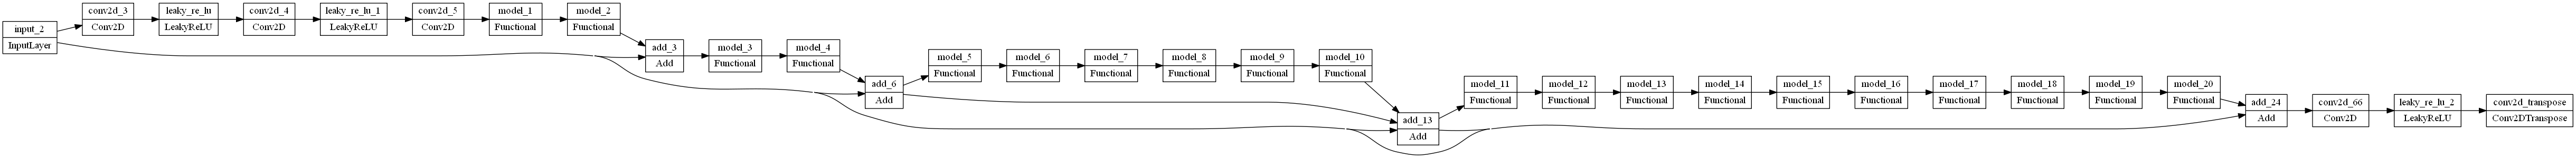

In [23]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

In [24]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [25]:
history = model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=5,callbacks=[checkpoint],
                    verbose=1 )

Epoch 1/5
584/584 [==============================] - ETA: 0s - loss: 462.2988 - accuracy: 0.8818

C:\Users\user\anaconda3\envs\cuda_tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


584/584 [==============================] - 28s 41ms/step - loss: 462.2988 - accuracy: 0.8818 - val_loss: 35.6915 - val_accuracy: 1.0000
Epoch 2/5
584/584 [==============================] - 24s 40ms/step - loss: 113.4656 - accuracy: 0.9396 - val_loss: 31.3332 - val_accuracy: 1.0000
Epoch 3/5
584/584 [==============================] - 23s 40ms/step - loss: 103.8800 - accuracy: 0.9400 - val_loss: 33.3586 - val_accuracy: 1.0000
Epoch 4/5
584/584 [==============================] - 22s 39ms/step - loss: 97.0136 - accuracy: 0.9426 - val_loss: 26.3001 - val_accuracy: 1.0000
Epoch 5/5
584/584 [==============================] - 24s 40ms/step - loss: 93.1429 - accuracy: 0.9437 - val_loss: 36.1604 - val_accuracy: 1.0000


In [26]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

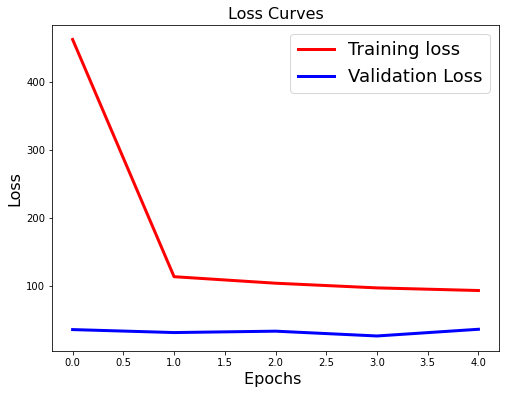

In [27]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

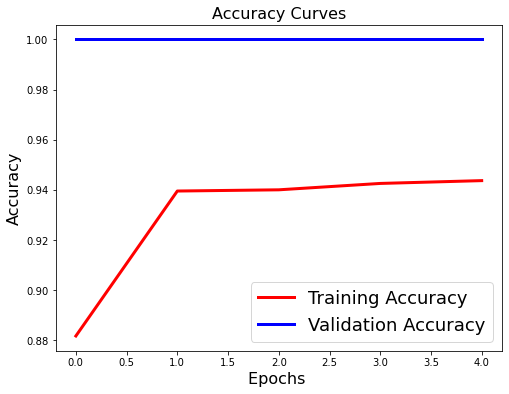

In [28]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [29]:
def psnr_calc():
    testimg = []
    GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
    GT = np.asarray(GT)
    h = GT.shape[0]
    l = GT.shape[1]
    img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
    img1 = np.asarray(img1)
    testimg.append(img1)
    testimg = np.asarray(testimg)
    print(testimg.shape)
    fin =(model.predict(testimg)[0])
    inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
    GT = GT[0:fin.shape[0],0:fin.shape[1],:]
    mse = np.square(np.subtract(GT, fin)).mean()
    #cv2_imshow(inp)
    #cv2_imshow(fin)
    #cv2_imshow(GT)
    import math
    psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
    return psnr

In [30]:
ps1 = psnr_calc()
print(ps1)

(1, 256, 256, 3)
30.54473668609


In [31]:
#35.27103087889881

In [ ]:
model.save("model2_FCN_FSRCNN.h5")